In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from tqdm.auto import tqdm


def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [2]:
# Check differences between two was of calculating values. 
from trajectory.gsolver import accel_acd, accel_xt

rows = []
for v_0, v_c, v_1 in tqdm(list(product(velocities,velocities, velocities))):
    x_ad, t_ad = accel_acd(v_0, v_c, v_1, a_max)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    rows.append( dict(x = x_ad - (x_a+x_d), t = t_ad -(t_a+t_d) ))
    
df = pd.DataFrame(rows)
                
df.describe()
    

  0%|          | 0/13824 [00:00<?, ?it/s]

,x,t
count,1.382400e+04,1.382400e+04
mean,-4.584248e-16,-5.398423e-19
std,1.117347e-14,6.388327e-18
min,-5.684342e-14,-2.775558e-17
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.136868e-13,2.775558e-17


In [4]:
# Test that values get passed through the Block sontructors. 
from trajectory.planner import  Joint

j = Joint(5_000, 50_000)
self = j.new_block(100,123,456)

assert self.x == 100, self.x
assert self.v_0 == 123
assert self.joint.v_max == 5_000

self = j.new_block(100,123,456)

assert self.x == 100
assert self.v_0 == 123
assert self.joint.v_max == 5_000


In [9]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, b, i, b.flag)
            if b.t != t:
                ot = b.t
                b.plan(ot)
                #assert round(self.t, 6) == round(ot, 6), (self.t, t)
                
            a = b.area
        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=self.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, a=a)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df))

  0%|          | 0/11520 [00:00<?, ?it/s]

# rows = 115200


NameError: name 'sl' is not defined

In [11]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList


# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i in tqdm(list(range(2_000))):

  
    x =   int(random() < .90)*randint(-10000,10000)
    v_0 = int(random() < .90)*randint(0, j.v_max)
    v_1 = int(random() < .90)*randint(0,j.v_max)
                
    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        a = x_e = None
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, self, i)
            if b.t != t:
                ot = b.t
                b.plan(ot)
               
            a = b.area
        except:
            errors.append( (i, x, v_0, v_1, tf))
            raise
        
        d = dict(i=i, x=x, t=self.t, v_0=b.v_0, v_1=b.v_1)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df), "# errors = ", len(errors) )
#df.qc.value_counts(normalize=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

# rows = 20000 # errors =  0


In [12]:
if errors:
    (i, x, v_0, v_1, tf)  = errors[0]
    print(i, x, v_0, v_1)
    self = j.new_block(x, v_0, v_1).init()
    t = self.t*tf
    try:
        self.plan(t)
    except:
        print(t, self.x, self.t, self.v_0, self.v_1, tf)

In [13]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm.auto import tqdm
from trajectory.planner import Joint, SegmentList


j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    try:
        b = j.new_block(x, v_0, v_1).init()
        t = b.t
    
        for tf in np.linspace(1.01, 3, num=10):
            b.plan(t * tf)
            b.plan_ramp(t*tf)
    except:
        errors.append( (i,  (x, v_0, v_1), tf) )
        raise
        

  0%|          | 0/11520 [00:00<?, ?it/s]

In [14]:
if errors:
    (i,  (x, v_0, v_1), tf) = errors[0]
    print(x, v_0, v_1, tf)
    
    #(x, v_0, v_1, tf) =  10,250,750,1.231111111111111


    self = j.new_block(x, v_0, v_1).init()
    t = self.t

    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
           
    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
    print(self)

0


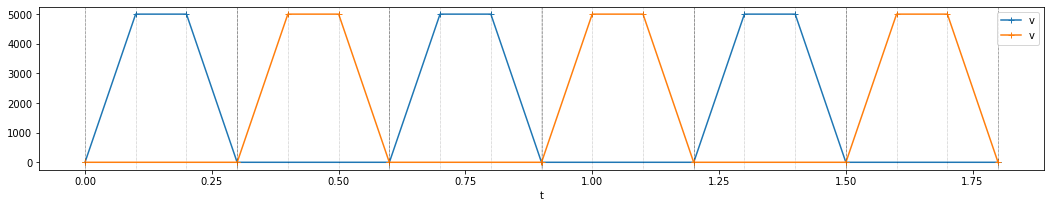

In [15]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.move([1000,1])
s = sl.move([1,1000])
s = sl.move([1000,1])
s = sl.move([1,1000])
s = sl.move([1000,1])
s = sl.move([1,1000])

print(len(list(sl.discontinuities())))

sl.plot()


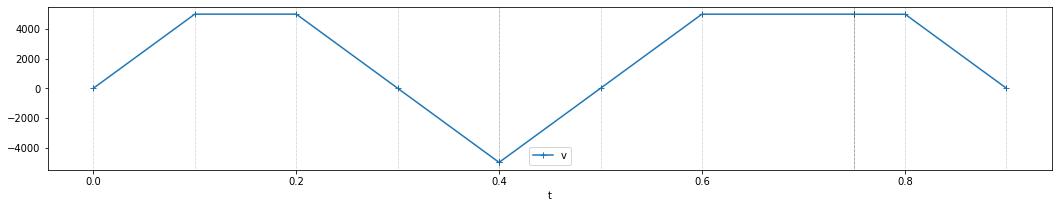

In [16]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*1

sl = SegmentList(joints)   
s = sl.move([1000])
s = sl.move([-500])
s = sl.move([1000])

s = sl.move([500])

sl.plot()

A  0.0
b  0.0
c  0.0
A  5000.0
b  0.0
c  0.0
A  7070.636228136724
b  0.4315837287515549
c  0.0
A  0.0
b  0.0
c  0.0
A  7751.9887125820815
b  0.0
c  0.0
A  7070.636228136724
b  0.4315837287515549
c  0.0
A  0.0
b  0.0
c  0.0
A  0.0
b  0.0
c  0.0
A  0.0
b  0.0
c  0.0
A  5000.0
b  0.0
c  0.0
A  0.0
b  0.0
c  0.0
A  5923.623067852985
b  0.5
c  0.0
(0, 0)(0, 0)(0, 0)(0, 0)(0, 0)(0, 0)(0, 0)(0, 0)(0, 1823)(0, 0)(0, 0)(0, 0)(911.5, 0)(0, 0)(0, 0)(0, 5000)(0, 5000)(0, 5000)(0, 0)(5000, 5000)(5000, 0)(5000, 0)(0, 0)(5000, 5000)(0, 0)(0, 0)(0, 5000)(5000, 5000)(0, 5000)(0, 414)(5000, 5000)(5000, 1250)(5000, 0)(414, 0)(5000, 0)(1250, 0)

/Users/eric/Documents/proj/trajectory/trajectory/plot.py:56: UserWarning: Found 1 discontinuities in axis 0
  warn(f"Found {discontinuities[0]} discontinuities in axis {axis}")


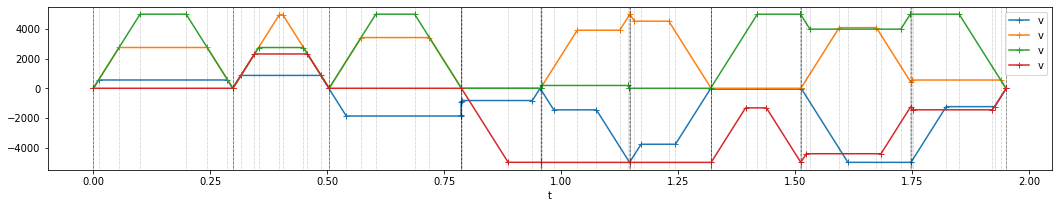

In [29]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Serious discontinuities. 
from trajectory import * 

j = Joint(5_000, 50_000)
joints = [j]*4
sl = SegmentList(joints)   
sl.move([160, 669, 991, 0])
sl.move([163, 529, 414, 369])
sl.move([-494, 733, 914, 0])
sl.move([-133, 0, 0, -596])
sl.move([-383, 606, 35, -955])
sl.move([-528, 583, 0, -868])
sl.move([-11, 0, 710, -524])
sl.move([-924, 658, 957, -940])
sl.move([-379, 110, 771, -275])

for s in sl:
    for b in s.blocks:
        print((b.v_0, b.v_1), end='')

sl.plot()

In [21]:
%%time 
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint
from tqdm.auto import tqdm

j = Joint(20_000, 500_000)
n = 6
joints = [j]*n
signs = [1]*n

sl = SegmentList(joints)   


def rand_move(axis):

    z = int(random() < .9) # Make 10% of the moves zero    
    signs[axis] = -signs[axis] if random() < .1 else signs[axis] # change direction 10% of the time

    return z * signs[axis] * randint(0,5000)
 
move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(5000) ]

for move_n, moves in tqdm(list(enumerate(move_sets))):
    try:
        sl.move(moves)
    except:
        print("Move=", move_n, move_sets[move_n])
        raise
 
def report_dis():
    ds = list(sl.discontinuities())
    if len(ds):
        print(f"Got {len(ds)} discontinuities") 
        for a, b in sl.discontinuities():
            be = sl.boundary_error(a.segment, b.segment)
            print(a.id, 'diff=',abs(a.v_1-b.v_0), a.v_1,'!=',b.v_0, "be=", be )

report_dis()
            
#df = sl.dataframe
#df = df[df.axis==0]
#sl.plot()
from collections import Counter
Counter(sl.replans).most_common(20)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 418 ms, total: 23.5 s
Wall time: 23.4 s


[(0, 3353),
 (2, 1329),
 (4, 207),
 (6, 36),
 (3, 30),
 (1, 20),
 (5, 14),
 (8, 6),
 (10, 2),
 (7, 1),
 (12, 1)]

In [ ]:
def align(s):
    
    t_a_m = t_d_m = 0
    
    for b in s.blocks:
        s.init()
        t_a_m = max(t_a_m, b.t_a)
        t_d_m = max(t_a_m, b.t_d)
        
    return t_a_m, t_d_m
    
t = pd.DataFrame( [align(s) for s in sl.segments], columns = ['t_a','t_d'])
print(t.mode())
t.describe()


In [ ]:
a=list('ABCD')
i = len(a)-1
a[i]

  0%|          | 0/100 [00:00<?, ?it/s]

1 [[4370, -1413, -4319, 3230], [1375, -1027, 3613, 473], [3295, -93, 555, 686], [3951, -363, 479, 1564], [516, -1085, 4433, 3405]]
[[4370, -1413, -4319, 3230], [1375, -1027, 3613, 473], [3295, -93, 555, 686], [3951, -363, 479, 1564], [516, -1085, 4433, 3405]]


/Users/eric/Documents/proj/trajectory/trajectory/plot.py:56: UserWarning: Found 1 discontinuities in axis 3
  warn(f"Found {discontinuities[0]} discontinuities in axis {axis}")


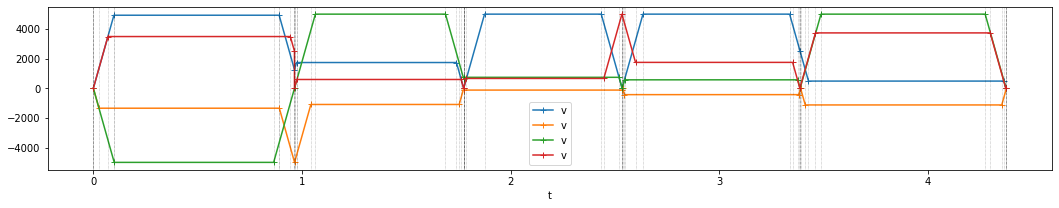

In [23]:
# Search for discontinuities
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint
from tqdm.auto import tqdm

j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

def f():
    for i in tqdm(list(range(100))):
        sl = SegmentList(joints)  
        move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(5) ]


        for move_n, moves in enumerate(move_sets):
            try:
                sl.move(moves)
            except:
                print("Move=", move_n, move_sets[move_n])
                return move_sets

        if i > 5 and len(list(sl.discontinuities())):
            ds = list(sl.discontinuities())
            print(len(ds), move_sets)   
            sl.plot()
            return move_sets
    else:
        print("Got Nothing")

move_sets = f()
print(move_sets)